In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [10]:
def build_2d_cnn_only_conv_ch_128_DO(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=128*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [11]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_128_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 253, 95, 128)      3328      
_________________________________________________________________
activation (Activation)      (None, 253, 95, 128)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 780288)            0         
_________________________________________________________________
dropout (Dropout)    

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4735 - acc: 0.5641
Epoch 00001: val_loss improved from inf to 1.33766, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_1_conv_checkpoint/001-1.3377.hdf5
36805/36805 [==============================] - 34s 932us/sample - loss: 1.4734 - acc: 0.5641 - val_loss: 1.3377 - val_acc: 0.6089
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9897 - acc: 0.7066
Epoch 00002: val_loss improved from 1.33766 to 1.13174, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_1_conv_checkpoint/002-1.1317.hdf5
36805/36805 [==============================] - 31s 829us/sample - loss: 0.9899 - acc: 0.7065 - val_loss: 1.1317 - val_acc: 0.6895
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7494 - acc: 0.7783
Epoch 00003: val_loss improved from 1.13174 to 1.08777, sav

Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0739 - acc: 0.9823
Epoch 00028: val_loss did not improve from 1.06322
36805/36805 [==============================] - 31s 852us/sample - loss: 0.0739 - acc: 0.9823 - val_loss: 1.5807 - val_acc: 0.7540
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0716 - acc: 0.9833
Epoch 00029: val_loss did not improve from 1.06322
36805/36805 [==============================] - 31s 849us/sample - loss: 0.0716 - acc: 0.9833 - val_loss: 1.6317 - val_acc: 0.7417
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0716 - acc: 0.9838
Epoch 00030: val_loss did not improve from 1.06322
36805/36805 [==============================] - 31s 840us/sample - loss: 0.0716 - acc: 0.9838 - val_loss: 1.6534 - val_acc: 0.7449
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9825
Epoch 00031: val_loss did not improve from 1.06322
36805/36805 [=====

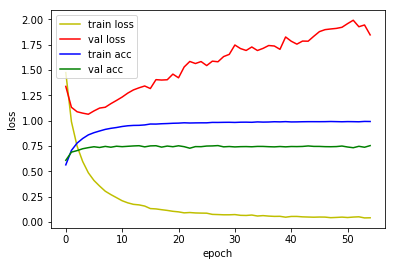

4815/4815 [==============================] - 3s 683us/sample - loss: 1.1574 - acc: 0.7067
Loss: 1.15736007462657 Accuracy: 0.70674974

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2102 - acc: 0.6415
Epoch 00001: val_loss improved from inf to 0.73919, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_2_conv_checkpoint/001-0.7392.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.2101 - acc: 0.6415 - val_loss: 0.7392 - val_acc: 0.8025
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5732 - acc: 0.8348
Epoch 00002: val_loss improved from 0.73919 to 0.53530, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_2_conv_checkpoint/002-0.5353.hdf5
36805/36805 [==============================] - 37s 999us/sample - loss: 0.5734 - acc: 0.8347 - val_loss: 0.5353 - val_acc: 0.8612
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9944
Epoch 00029: val_loss did not improve from 0.44184
36805/36805 [==============================] - 37s 996us/sample - loss: 0.0226 - acc: 0.9944 - val_loss: 0.6789 - val_acc: 0.9043
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9945
Epoch 00030: val_loss did not improve from 0.44184
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0220 - acc: 0.9945 - val_loss: 0.6547 - val_acc: 0.9026
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9946
Epoch 00031: val_loss did not improve from 0.44184
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0217 - acc: 0.9946 - val_loss: 0.6489 - val_acc: 0.9115
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9950
Epoch 00032: val_loss did not improve from 0.44184
36805/36805 [=========

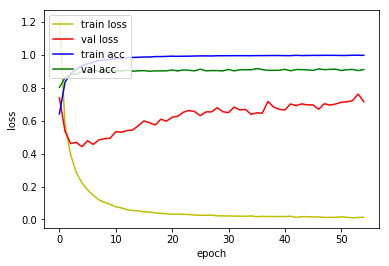

4815/4815 [==============================] - 4s 827us/sample - loss: 0.5208 - acc: 0.8687
Loss: 0.520803261446928 Accuracy: 0.86874354

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1160 - acc: 0.6620
Epoch 00001: val_loss improved from inf to 0.54924, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_3_conv_checkpoint/001-0.5492.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.1159 - acc: 0.6620 - val_loss: 0.5492 - val_acc: 0.8516
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4680 - acc: 0.8597
Epoch 00002: val_loss improved from 0.54924 to 0.37516, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_3_conv_checkpoint/002-0.3752.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.4681 - acc: 0.8597 - val_loss: 0.3752 - val_acc: 0.9038
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9932
Epoch 00028: val_loss did not improve from 0.23735
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0244 - acc: 0.9932 - val_loss: 0.3215 - val_acc: 0.9502
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9924
Epoch 00029: val_loss did not improve from 0.23735
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0258 - acc: 0.9924 - val_loss: 0.3614 - val_acc: 0.9455
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9924
Epoch 00030: val_loss did not improve from 0.23735
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0252 - acc: 0.9924 - val_loss: 0.3586 - val_acc: 0.9492
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9940
Epoch 00031: val_loss did not improve from 0.23735
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9952
Epoch 00058: val_loss did not improve from 0.23735
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0175 - acc: 0.9952 - val_loss: 0.3686 - val_acc: 0.9532
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0140 - acc: 0.9964
Epoch 00059: val_loss did not improve from 0.23735
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0140 - acc: 0.9964 - val_loss: 0.3851 - val_acc: 0.9506

2D_CNN_only_conv_ch_128_DO_3_conv Model


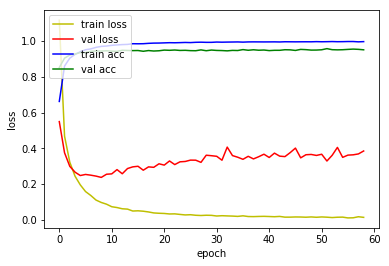

4815/4815 [==============================] - 4s 913us/sample - loss: 0.3050 - acc: 0.9192
Loss: 0.3049768604933906 Accuracy: 0.9192108

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2039 - acc: 0.6228
Epoch 00001: val_loss improved from inf to 0.54696, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_4_conv_checkpoint/001-0.5470.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.2040 - acc: 0.6228 - val_loss: 0.5470 - val_acc: 0.8507
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5210 - acc: 0.8398
Epoch 00002: val_loss improved from 0.54696 to 0.36251, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_4_conv_checkpoint/002-0.3625.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5209 - acc: 0.8398 - val_loss: 0.3625 - val_acc: 0.8940
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9907
Epoch 00027: val_loss did not improve from 0.15243
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0308 - acc: 0.9907 - val_loss: 0.2066 - val_acc: 0.9625
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9899
Epoch 00028: val_loss did not improve from 0.15243
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0317 - acc: 0.9899 - val_loss: 0.2039 - val_acc: 0.9639
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9903
Epoch 00029: val_loss did not improve from 0.15243
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0311 - acc: 0.9903 - val_loss: 0.1980 - val_acc: 0.9646
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9915
Epoch 00030: val_loss did not improve from 0.15243
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9953
Epoch 00057: val_loss did not improve from 0.15243
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0155 - acc: 0.9953 - val_loss: 0.2407 - val_acc: 0.9655
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0164 - acc: 0.9952
Epoch 00058: val_loss did not improve from 0.15243
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0164 - acc: 0.9952 - val_loss: 0.2304 - val_acc: 0.9665
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9957
Epoch 00059: val_loss did not improve from 0.15243
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0146 - acc: 0.9957 - val_loss: 0.2423 - val_acc: 0.9627
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9958
Epoch 00060: val_loss did not improve from 0.15243
36805/36805 [===========

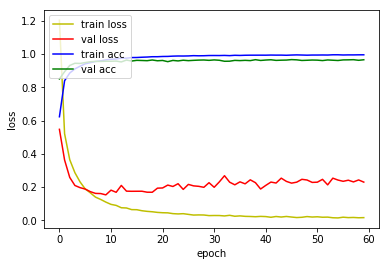

4815/4815 [==============================] - 5s 959us/sample - loss: 0.2247 - acc: 0.9373
Loss: 0.224739184593424 Accuracy: 0.93727934



In [12]:
for i in range(1, 5):
    base = '2D_CNN_only_conv_ch_128_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_only_conv_ch_128_DO(conv_num=i)
    
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [14]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '2D_CNN_only_conv_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 5):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


2D_CNN_only_conv_ch_128_DO_1_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 257, 99, 1)   0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 257, 99, 1)   0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 257, 99, 1)   0           input_5[0][0]                    
__________________________________________________________________________________________________
model_4 (Model)                 (None, 16)           12487952    lambda[0][0]                     
                                                                 lam

In [15]:
def build_2d_cnn_only_conv_ch_128_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=128*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = BatchNormalization()(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [16]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_128_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 253, 95, 128)      3328      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 128)      512       
_________________________________________________________________
activation_20 (Activation)   (None, 253, 95, 128)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 48, 128)      0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 780288)            0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 780288)            3121152   
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.6953 - acc: 0.4914
Epoch 00001: val_loss improved from inf to 4.28558, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_BN_1_conv_checkpoint/001-4.2856.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 5.6964 - acc: 0.4913 - val_loss: 4.2856 - val_acc: 0.6075
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.8534 - acc: 0.6605
Epoch 00002: val_loss did not improve from 4.28558
36805/36805 [==============================] - 68s 2ms/sample - loss: 3.8546 - acc: 0.6605 - val_loss: 4.3736 - val_acc: 0.6152
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1052 - acc: 0.7287
Epoch 00003: val_loss did not improve from 4.28558
36805/36805 [==============================] - 68s 2ms/sample - loss: 3.1063 - acc: 0.7287 - val_loss: 4.5358 - val_acc: 0.6117
Epoch 4/500
36800/36805 [======

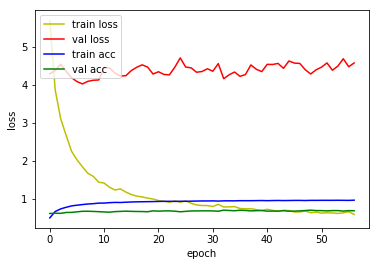

4815/4815 [==============================] - 4s 813us/sample - loss: 4.5455 - acc: 0.6332
Loss: 4.545488372794812 Accuracy: 0.6332295

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6546 - acc: 0.6077
Epoch 00001: val_loss improved from inf to 1.12749, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_BN_2_conv_checkpoint/001-1.1275.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.6547 - acc: 0.6076 - val_loss: 1.1275 - val_acc: 0.7321
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8063 - acc: 0.7961
Epoch 00002: val_loss improved from 1.12749 to 1.02967, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_BN_2_conv_checkpoint/002-1.0297.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.8063 - acc: 0.7961 - val_loss: 1.0297 - val_acc: 0.7813
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9878
Epoch 00029: val_loss did not improve from 0.97905
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0464 - acc: 0.9878 - val_loss: 1.3973 - val_acc: 0.8279
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9873
Epoch 00030: val_loss did not improve from 0.97905
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0532 - acc: 0.9872 - val_loss: 1.4406 - val_acc: 0.8341
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0742 - acc: 0.9815
Epoch 00031: val_loss did not improve from 0.97905
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0745 - acc: 0.9815 - val_loss: 1.4992 - val_acc: 0.8267
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0714 - acc: 0.9830
Epoch 00032: val_loss did not improve from 0.97905
36805/36805 [===========

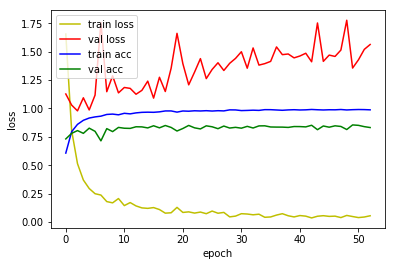

4815/4815 [==============================] - 4s 933us/sample - loss: 1.1089 - acc: 0.7805
Loss: 1.1089270783609566 Accuracy: 0.7804777

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2710 - acc: 0.6451
Epoch 00001: val_loss improved from inf to 0.83871, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_BN_3_conv_checkpoint/001-0.8387.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 1.2711 - acc: 0.6451 - val_loss: 0.8387 - val_acc: 0.7887
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6007 - acc: 0.8295
Epoch 00002: val_loss improved from 0.83871 to 0.59931, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_BN_3_conv_checkpoint/002-0.5993.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.6007 - acc: 0.8295 - val_loss: 0.5993 - val_acc: 0.8465
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0519 - acc: 0.9845
Epoch 00028: val_loss did not improve from 0.40570
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0525 - acc: 0.9844 - val_loss: 0.5049 - val_acc: 0.9217
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9870
Epoch 00029: val_loss did not improve from 0.40570
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.0417 - acc: 0.9870 - val_loss: 0.5555 - val_acc: 0.9227
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9870
Epoch 00030: val_loss did not improve from 0.40570
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0430 - acc: 0.9870 - val_loss: 0.5607 - val_acc: 0.9194
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9845
Epoch 00031: val_loss did not improve from 0.40570
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9942
Epoch 00058: val_loss did not improve from 0.40570
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0221 - acc: 0.9942 - val_loss: 0.5688 - val_acc: 0.9292
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0233 - acc: 0.9936
Epoch 00059: val_loss did not improve from 0.40570
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0233 - acc: 0.9936 - val_loss: 0.6226 - val_acc: 0.9192
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9942
Epoch 00060: val_loss did not improve from 0.40570
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0214 - acc: 0.9941 - val_loss: 0.6284 - val_acc: 0.9248
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9925
Epoch 00061: val_loss did not improve from 0.40570
36805/36805 [===========

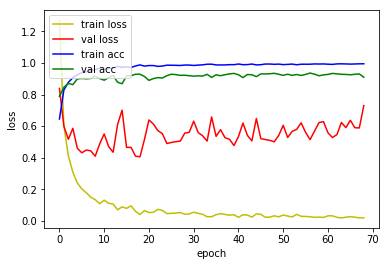

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5480 - acc: 0.8991
Loss: 0.548018490277842 Accuracy: 0.89906543

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0773 - acc: 0.6762
Epoch 00001: val_loss improved from inf to 0.65113, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_BN_4_conv_checkpoint/001-0.6511.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 1.0774 - acc: 0.6762 - val_loss: 0.6511 - val_acc: 0.8227
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4559 - acc: 0.8653
Epoch 00002: val_loss improved from 0.65113 to 0.35187, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_BN_4_conv_checkpoint/002-0.3519.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.4562 - acc: 0.8652 - val_loss: 0.3519 - val_acc: 0.9073
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9963
Epoch 00026: val_loss did not improve from 0.18017
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.0156 - acc: 0.9963 - val_loss: 0.1905 - val_acc: 0.9548
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9923
Epoch 00027: val_loss did not improve from 0.18017
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0267 - acc: 0.9923 - val_loss: 0.2036 - val_acc: 0.9539
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9963
Epoch 00028: val_loss did not improve from 0.18017
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.0149 - acc: 0.9963 - val_loss: 0.2122 - val_acc: 0.9497
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9909
Epoch 00029: val_loss did not improve from 0.18017
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9958
Epoch 00056: val_loss did not improve from 0.18017
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0160 - acc: 0.9958 - val_loss: 0.1971 - val_acc: 0.9583
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.9985
Epoch 00057: val_loss did not improve from 0.18017
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0067 - acc: 0.9985 - val_loss: 0.2165 - val_acc: 0.9557
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9986
Epoch 00058: val_loss did not improve from 0.18017
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0062 - acc: 0.9985 - val_loss: 0.2034 - val_acc: 0.9590
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9955
Epoch 00059: val_loss did not improve from 0.18017
36805/36805 [===========

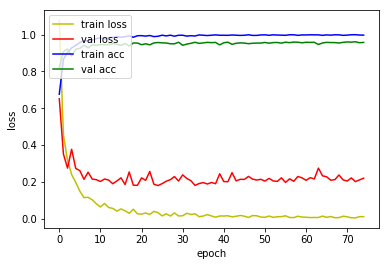

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2431 - acc: 0.9369
Loss: 0.24305657878255052 Accuracy: 0.93686396



In [17]:
for i in range(1, 5):
    base = '2D_CNN_only_conv_ch_128_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_only_conv_ch_128_BN(conv_num=i)
    
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [10]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '2D_CNN_only_conv_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 5):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


2D_CNN_only_conv_ch_128_BN_1_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 257, 99, 1)   0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 257, 99, 1)   0           input_13[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 257, 99, 1)   0           input_13[0][0]                   
__________________________________________________________________________________________________
model_16 (Model)                (None, 16)     

In [11]:
def build_2d_cnn_only_conv_ch_128_DO_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=128*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [12]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_128_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 253, 95, 128)      3328      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 128)      512       
_________________________________________________________________
activation (Activation)      (None, 253, 95, 128)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 780288)            0         
___________________________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.4863 - acc: 0.4676
Epoch 00001: val_loss improved from inf to 4.71971, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_BN_1_conv_checkpoint/001-4.7197.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 5.4861 - acc: 0.4676 - val_loss: 4.7197 - val_acc: 0.5353
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.3813 - acc: 0.5714
Epoch 00002: val_loss improved from 4.71971 to 4.48974, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_BN_1_conv_checkpoint/002-4.4897.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 4.3812 - acc: 0.5714 - val_loss: 4.4897 - val_acc: 0.5425
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.9299 - acc: 0.6216
Epoch 00003: val_loss improved from 4.48974 to 4.30339, saving model to model/checkpoint/2D_CNN_only_conv

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3947 - acc: 0.8258
Epoch 00029: val_loss did not improve from 4.14667
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.3944 - acc: 0.8258 - val_loss: 4.3796 - val_acc: 0.6494
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3654 - acc: 0.8295
Epoch 00030: val_loss did not improve from 4.14667
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.3651 - acc: 0.8295 - val_loss: 4.5166 - val_acc: 0.6394
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3672 - acc: 0.8289
Epoch 00031: val_loss did not improve from 4.14667
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.3668 - acc: 0.8290 - val_loss: 4.3963 - val_acc: 0.6485
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3497 - acc: 0.8326
Epoch 00032: val_loss did not improve from 4.14667
36805/36805 [===========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2739 - acc: 0.8474
Epoch 00059: val_loss did not improve from 4.14667
36805/36805 [==============================] - 57s 2ms/sample - loss: 2.2736 - acc: 0.8474 - val_loss: 4.5028 - val_acc: 0.6606

2D_CNN_only_conv_ch_128_DO_BN_1_conv Model


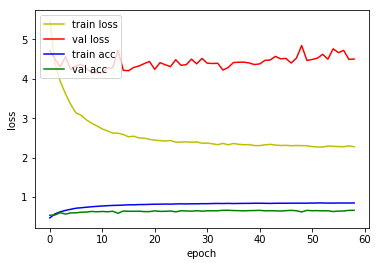

4815/4815 [==============================] - 4s 817us/sample - loss: 4.9739 - acc: 0.6191
Loss: 4.973870948640976 Accuracy: 0.61910695

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5644 - acc: 0.5550
Epoch 00001: val_loss improved from inf to 1.08615, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_BN_2_conv_checkpoint/001-1.0861.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.5643 - acc: 0.5550 - val_loss: 1.0861 - val_acc: 0.6874
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7904 - acc: 0.7606
Epoch 00002: val_loss improved from 1.08615 to 0.84685, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_BN_2_conv_checkpoint/002-0.8468.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.7904 - acc: 0.7605 - val_loss: 0.8468 - val_acc: 0.7512
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0724 - acc: 0.9776
Epoch 00028: val_loss did not improve from 0.49498
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0723 - acc: 0.9776 - val_loss: 0.5656 - val_acc: 0.9038
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9796
Epoch 00029: val_loss did not improve from 0.49498
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0653 - acc: 0.9796 - val_loss: 0.6258 - val_acc: 0.8970
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9788
Epoch 00030: val_loss did not improve from 0.49498
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0693 - acc: 0.9788 - val_loss: 0.5850 - val_acc: 0.8963
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9842
Epoch 00031: val_loss did not improve from 0.49498
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9939
Epoch 00058: val_loss did not improve from 0.49498
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0226 - acc: 0.9939 - val_loss: 0.6527 - val_acc: 0.9003
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9939
Epoch 00059: val_loss did not improve from 0.49498
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0249 - acc: 0.9939 - val_loss: 0.6734 - val_acc: 0.8959

2D_CNN_only_conv_ch_128_DO_BN_2_conv Model


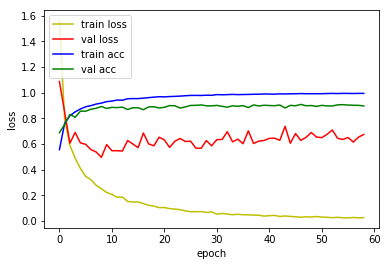

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6824 - acc: 0.8374
Loss: 0.6823647920711513 Accuracy: 0.83738315

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4168 - acc: 0.5818
Epoch 00001: val_loss improved from inf to 0.64047, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_BN_3_conv_checkpoint/001-0.6405.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 1.4166 - acc: 0.5818 - val_loss: 0.6405 - val_acc: 0.8244
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6412 - acc: 0.8069
Epoch 00002: val_loss improved from 0.64047 to 0.50877, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_BN_3_conv_checkpoint/002-0.5088.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 0.6412 - acc: 0.8069 - val_loss: 0.5088 - val_acc: 0.8691
Epoch 3/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0653 - acc: 0.9797
Epoch 00026: val_loss did not improve from 0.26842
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.0653 - acc: 0.9797 - val_loss: 0.2770 - val_acc: 0.9499
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0563 - acc: 0.9817
Epoch 00027: val_loss did not improve from 0.26842
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.0563 - acc: 0.9817 - val_loss: 0.2766 - val_acc: 0.9464
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0552 - acc: 0.9833
Epoch 00028: val_loss did not improve from 0.26842
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.0552 - acc: 0.9832 - val_loss: 0.3543 - val_acc: 0.9394
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9821
Epoch 00029: val_loss did not improve from 0.26842
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9946
Epoch 00056: val_loss did not improve from 0.26842
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.0194 - acc: 0.9946 - val_loss: 0.3269 - val_acc: 0.9488
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9941
Epoch 00057: val_loss did not improve from 0.26842
36805/36805 [==============================] - 101s 3ms/sample - loss: 0.0214 - acc: 0.9941 - val_loss: 0.4290 - val_acc: 0.9362
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9932
Epoch 00058: val_loss did not improve from 0.26842
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.0234 - acc: 0.9932 - val_loss: 0.3337 - val_acc: 0.9497
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9911
Epoch 00059: val_loss did not improve from 0.26842
36805/36805 [========

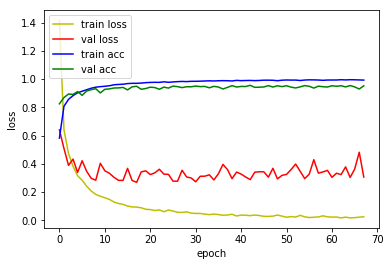

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3950 - acc: 0.9236
Loss: 0.39498677346497574 Accuracy: 0.9235722

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4036 - acc: 0.5691
Epoch 00001: val_loss improved from inf to 0.58377, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_BN_4_conv_checkpoint/001-0.5838.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 1.4034 - acc: 0.5692 - val_loss: 0.5838 - val_acc: 0.8290
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5787 - acc: 0.8202
Epoch 00002: val_loss improved from 0.58377 to 0.32727, saving model to model/checkpoint/2D_CNN_only_conv_ch_128_DO_BN_4_conv_checkpoint/002-0.3273.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.5786 - acc: 0.8202 - val_loss: 0.3273 - val_acc: 0.9068
Epoch 3/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9908
Epoch 00027: val_loss did not improve from 0.14646
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0310 - acc: 0.9908 - val_loss: 0.2076 - val_acc: 0.9522
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9863
Epoch 00028: val_loss did not improve from 0.14646
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0449 - acc: 0.9863 - val_loss: 0.2050 - val_acc: 0.9599
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9911
Epoch 00029: val_loss did not improve from 0.14646
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0299 - acc: 0.9911 - val_loss: 0.1809 - val_acc: 0.9611
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9900
Epoch 00030: val_loss did not improve from 0.14646
36805/36805 [=====================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9961
Epoch 00057: val_loss did not improve from 0.14646
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0134 - acc: 0.9961 - val_loss: 0.2596 - val_acc: 0.9509
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9970
Epoch 00058: val_loss did not improve from 0.14646
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0113 - acc: 0.9970 - val_loss: 0.1908 - val_acc: 0.9676
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9963
Epoch 00059: val_loss did not improve from 0.14646
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0130 - acc: 0.9963 - val_loss: 0.1887 - val_acc: 0.9667
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9947
Epoch 00060: val_loss did not improve from 0.14646
36805/36805 [========

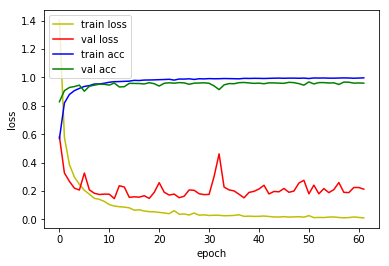

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1863 - acc: 0.9518
Loss: 0.18630370420354456 Accuracy: 0.9518172



In [13]:
for i in range(1, 5):
    base = '2D_CNN_only_conv_ch_128_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_only_conv_ch_128_DO_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [14]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '2D_CNN_only_conv_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 5):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


2D_CNN_only_conv_ch_128_DO_BN_1_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 257, 99, 1)   0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 257, 99, 1)   0           input_21[0][0]                   
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 257, 99, 1)   0           input_21[0][0]                   
__________________________________________________________________________________________________
model_28 (Model)                (None, 16)           12488464    lambda_16[0][0]                  
                                                                 